### **1. Import Libraries**
Description: Import necessary Python libraries for data manipulation, machine learning, and visualization.
- **pandas**: Used for handling and manipulating structured data (e.g., DataFrames).
- **numpy**: Provides support for numerical operations and array handling.
- **matplotlib.pyplot**: Enables plotting and visualization of results (e.g., class imbalance, metrics).
- **sklearn** modules: Provide tools for preprocessing (StandardScaler), model training (RandomForestClassifier),
    evaluation (accuracy_score, classification_report, etc.), and data splitting (train_test_split).

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

### **2. Define Data Paths**
Description: Store file paths to the gene expression counts data and metadata for CLL and T2D in a dictionary.
This centralizes file references, making it easier to manage and update paths if needed.

In [4]:
data_paths = {
    "cll_counts": "Data for ML_CLL/Countsdata/GSE70830_counts_data.csv",
    "cll_metadata": "Data for ML_CLL/Metadata/GSE70830_metadata.csv",
    "t2d_counts": "Data for ML_CLL/Countsdata/GSE159984_counts_data.csv",
    "t2d_metadata": "Data for ML_CLL/Metadata/GSE159984_metadata.csv",
}

### **3. Load Datasets**
Description: Load the gene expression counts data and metadata from CSV files into pandas DataFrames.
- Counts data contains gene expression levels for each sample.
- Metadata includes sample information (e.g., disease condition).
- index_col=0 sets the first column as the DataFrame index (e.g., gene symbols or sample IDs).

In [5]:
# Load CLL dataset
cll_counts = pd.read_csv(data_paths["cll_counts"], index_col=0)
cll_metadata = pd.read_csv(data_paths["cll_metadata"])

# Load T2D dataset
t2d_counts = pd.read_csv(data_paths["t2d_counts"], index_col=0)
t2d_metadata = pd.read_csv(data_paths["t2d_metadata"])

### **4. Label Metadata**
Description: Assign binary labels to metadata based on the "Condition" column to indicate disease state.
- 1 represents "Case" (disease present, e.g., CLL or T2D).
- 0 represents "Control" (healthy, no disease).

A lambda function is applied to create a new column with these labels.

In [6]:
# Label CLL metadata
cll_metadata["cll_label"] = cll_metadata["Condition"].apply(lambda x: 1 if x == "Case" else 0)
# Label T2D metadata
t2d_metadata["t2d_label"] = t2d_metadata["Condition"].apply(lambda x: 1 if x == "Case" else 0)

### **5. Preprocess Counts Data**
#Description: Transform the counts data into a suitable format for analysis.
- Set **'gene_symbol'** as the index to organize data by genes.
- Transpose the DataFrame so samples are rows and genes are columns, aligning with typical machine learning input.
- Name the index **'GSM'** to represent sample IDs.
- Add disease labels from metadata to the counts DataFrame.
- Ensure column names are strings, handling cases where they might be tuples or other types.

In [7]:
# Preprocess CLL data
cll_counts = cll_counts.set_index('gene_symbol').T
cll_counts.index.name = 'GSM'
cll_counts['cll_label'] = cll_metadata['cll_label'].values
cll_counts.columns = [col if isinstance(col, str) else col[0] for col in cll_counts.columns]

# Preprocess T2D data
t2d_counts = t2d_counts.set_index('gene_symbol').T
t2d_counts.index.name = 'GSM'
t2d_counts['t2d_label'] = t2d_metadata['t2d_label'].values
t2d_counts.columns = [col if isinstance(col, str) else col[0] for col in t2d_counts.columns]

### **6. Check Data Quality and Save**
Description: Perform quality checks on the datasets to ensure they are suitable for analysis.
- **check_missing_values:** Identifies columns with missing values, which could affect model performance if not handled.
- **check_duplicates:** Detects duplicate rows, which could skew results if present.
- Save the preprocessed dataset for future works

In [8]:
# Check for missing values
def check_missing_values(df):
    missing_values = df.isnull().sum()
    return missing_values[missing_values > 0]

cll_missing = check_missing_values(cll_counts)
t2d_missing = check_missing_values(t2d_counts)
print("CLL Missing Values:\n", cll_missing)
print("T2D Missing Values:\n", t2d_missing)

# Check for duplicates
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    return duplicates

cll_duplicates = check_duplicates(cll_counts)
t2d_duplicates = check_duplicates(t2d_counts)
print("CLL Duplicates:", cll_duplicates)
print("T2D Duplicates:", t2d_duplicates)

CLL Missing Values:
 Series([], dtype: int64)
T2D Missing Values:
 Series([], dtype: int64)
CLL Duplicates: 0
T2D Duplicates: 0


In [9]:
# Save the dataframes to CSV
cll_counts.to_csv("clean_data/clean_cll_counts.csv")
t2d_counts.to_csv("clean_data/clean_t2d_counts.csv")

### **7. Separate Features and Labels**
Description: Split the dataset into features (X) and labels (y) for machine learning.
- X: Gene expression values used as input features.
- y: Binary disease labels (0 or 1) used as the target variable.

In [10]:
def separate_features_labels(df, label_col):
    X = df.drop(columns=[label_col])
    y = df[label_col]
    return X, y

cll_X, cll_y = separate_features_labels(cll_counts, 'cll_label')
t2d_X, t2d_y = separate_features_labels(t2d_counts, 't2d_label')

### **8. Check Class Imbalance**
Description: Assess the distribution of disease cases (1) and controls (0) in the labels.
- Imbalanced classes (e.g., many more controls than cases) can bias the model.
- Visualization with bar plots helps interpret the imbalance visually.

In [11]:
def check_class_imbalance(y):
    class_counts = y.value_counts()
    return class_counts

cll_class_counts = check_class_imbalance(cll_y)
t2d_class_counts = check_class_imbalance(t2d_y)
print("CLL Class Counts:\n", cll_class_counts)
print("T2D Class Counts:\n", t2d_class_counts)

CLL Class Counts:
 cll_label
1    10
0     5
Name: count, dtype: int64
T2D Class Counts:
 t2d_label
0    103
1     28
Name: count, dtype: int64


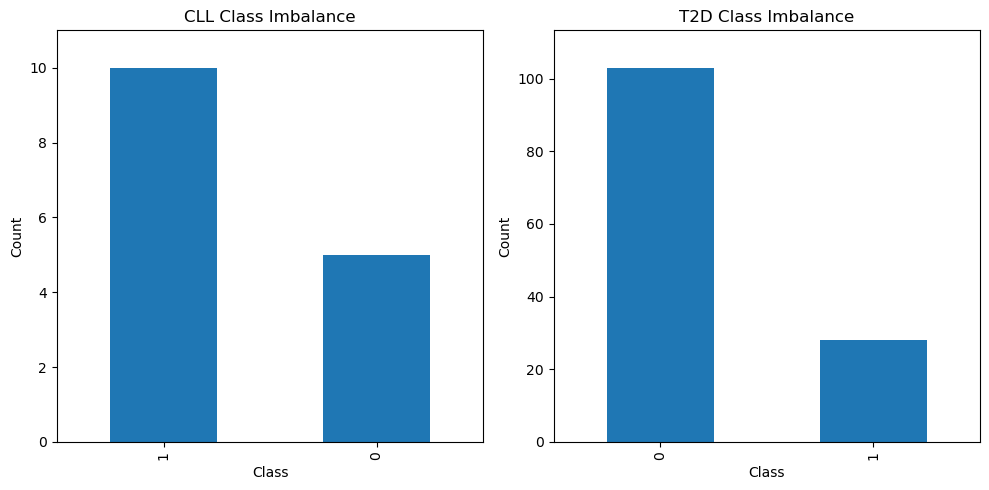

In [12]:
class_counts_dict = {"CLL": cll_class_counts, "T2D": t2d_class_counts}
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.flatten()

for ax, (name, counts) in zip(axs, class_counts_dict.items()):
    counts.plot(kind="bar", ax=ax)
    ax.set_title(f"{name} Class Imbalance")
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    ax.set_ylim(0, counts.max() * 1.1)

plt.tight_layout()
plt.show()

### **9. Scale Features**
Description: Standardize the gene expression features to have a mean of 0 and variance of 1.
- Standardization ensures all features contribute equally to the model, preventing dominance by features with larger scales.
- **StandardScaler** is used to transform the data.

In [13]:
def scale_features(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

cll_X_scaled = scale_features(cll_X)
t2d_X_scaled = scale_features(t2d_X)

### **10. Train-Test Split**
Description: Divide the dataset into training and testing sets to evaluate model performance.
- 80% of data is used for training, 20% for testing (test_size=0.2).
- **random_state=42** ensures reproducibility of the split.

In [14]:
def train_test_split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

cll_X_train, cll_X_test, cll_y_train, cll_y_test = train_test_split_data(cll_X_scaled, cll_y)
t2d_X_train, t2d_X_test, t2d_y_train, t2d_y_test = train_test_split_data(t2d_X_scaled, t2d_y)

### **11. Train Random Forest Classifier**
Description: Train a Random Forest Classifier on the training data to predict disease states.
- Random Forest is an ensemble method that builds multiple decision trees and aggregates their predictions.
- **random_state=42** ensures consistent results across runs.

In [15]:
def train_random_forest(X_train, y_train):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train, y_train)
    return rf

cll_rf = train_random_forest(cll_X_train, cll_y_train)
t2d_rf = train_random_forest(t2d_X_train, t2d_y_train)

### **12. Evaluate Models**
Description: Assess model performance on the test set using accuracy and detailed metrics.
- **Accuracy** measures the proportion of correct predictions.
- Classification report provides **Precision**, **Recall**, and **F1-score** for a comprehensive evaluation.

In [16]:
import warnings
warnings.filterwarnings("ignore")

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

cll_accuracy, cll_report = evaluate_model(cll_rf, cll_X_test, cll_y_test)
t2d_accuracy, t2d_report = evaluate_model(t2d_rf, t2d_X_test, t2d_y_test)

print("CLL Model Evaluation:")
print("Accuracy:", cll_accuracy)
print("Classification Report:\n", cll_report)
print("T2D Model Evaluation:")
print("Accuracy:", t2d_accuracy)
print("Classification Report:\n", t2d_report)

CLL Model Evaluation:
Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

T2D Model Evaluation:
Accuracy: 0.8148148148148148
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       0.75      0.43      0.55         7

    accuracy                           0.81        27
   macro avg       0.79      0.69      0.71        27
weighted avg       0.81      0.81      0.80        27



### **13. Cross-Validation**
Description: Perform 5-fold cross-validation to evaluate model robustness and generalizability.
- The dataset is split into 5 parts; the model trains on 4 and tests on 1, repeating for all combinations.
- Mean score provides a reliable estimate of performance across different data subsets.

In [17]:
def cross_validate_model(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv)
    return scores

cll_cv_scores = cross_validate_model(cll_rf, cll_X_scaled, cll_y)
t2d_cv_scores = cross_validate_model(t2d_rf, t2d_X_scaled, t2d_y)

print("CLL Cross-validation Mean Score:", cll_cv_scores.mean())
print("T2D Cross-validation Mean Score:", t2d_cv_scores.mean())

CLL Cross-validation Mean Score: 0.8666666666666666
T2D Cross-validation Mean Score: 0.8173789173789174


### **14. Visualize Model Metrics**
Description: Create a bar plot to compare performance metrics (accuracy, precision, recall, F1-score) across CLL and T2D models.
- Visual representation aids in understanding model strengths and weaknesses.

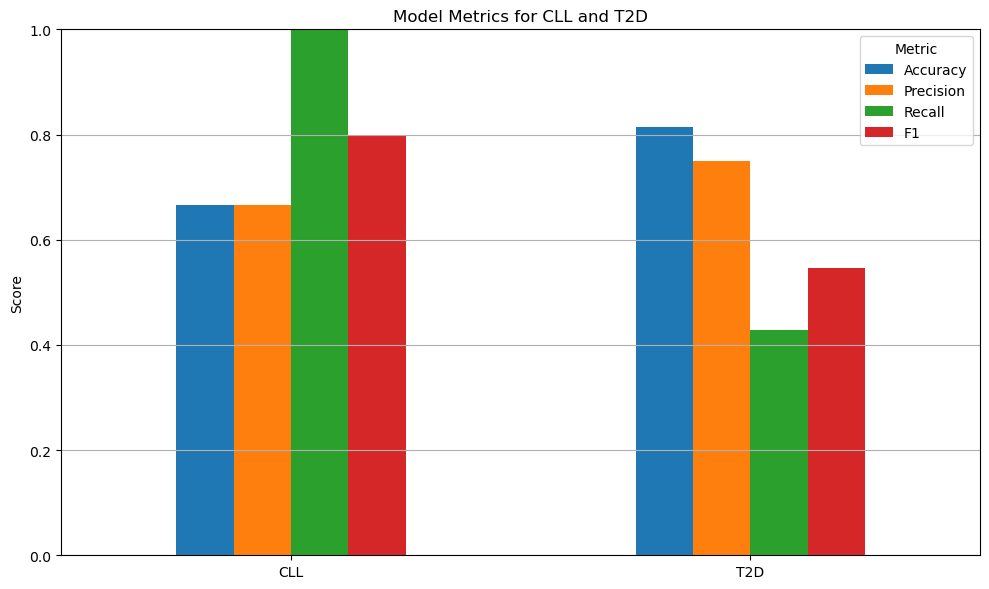

In [18]:
datasets = {"CLL": (cll_rf, cll_X_test, cll_y_test), "T2D": (t2d_rf, t2d_X_test, t2d_y_test)}
metrics = {}
for name, (model, X_test, y_test) in datasets.items():
    y_pred = model.predict(X_test)
    metrics[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='binary'),
        "Recall": recall_score(y_test, y_pred, average='binary'),
        "F1": f1_score(y_test, y_pred, average='binary')
    }

metrics_df = pd.DataFrame(metrics).T
ax = metrics_df.plot(kind="bar", figsize=(10, 6))
ax.set_ylim(0, 1)
plt.title("Model Metrics for CLL and T2D")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### **15. Extract Feature Importances**
Description: Identify the most influential genes (features) in the Random Forest models.
- Feature importance scores indicate each gene's contribution to the classification.
- Only genes with non-zero importance are retained for further analysis.

In [19]:
def get_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_importances = pd.Series(importances[indices], index=feature_names[indices])
    return feature_importances[feature_importances > 0]

cll_feature_importances = get_feature_importances(cll_rf, cll_X.columns)
t2d_feature_importances = get_feature_importances(t2d_rf, t2d_X.columns)

print("CLL Feature Importances:\n", cll_feature_importances)
print("Total Number of Features for CLL:", len(cll_feature_importances))
print("T2D Feature Importances:\n", t2d_feature_importances)
print("Total Number of Features for T2D:", len(t2d_feature_importances))

CLL Feature Importances:
 ATXN7           0.020202
GSS             0.020202
TRIM10          0.010101
LOC100506178    0.010101
HOXD1           0.010101
                  ...   
SVIP            0.010101
LINC00664       0.010101
LINC00658       0.010101
MLH1            0.010101
AMZ2            0.010101
Length: 97, dtype: float64
Total Number of Features for CLL: 97
T2D Feature Importances:
 MPC1         0.011411
ABHD10       0.010811
TBPL1        0.010044
ZNF823       0.007216
DRAM2        0.006935
               ...   
FGFRL1       0.000279
ARHGAP29     0.000272
RAB40A       0.000258
CYP2F1       0.000216
LINC01538    0.000160
Length: 548, dtype: float64
Total Number of Features for T2D: 548


In [20]:
# Save feature importances to CSV
cll_feature_importances.to_csv("results/cll_feature_importances.csv")
t2d_feature_importances.to_csv("results/t2d_feature_importances.csv")

### **16. Identify Common Biomarkers**
Description: Find genes that are important in both CLL and T2D models by intersecting their important features.
- Common biomarkers may indicate shared biological mechanisms between the two diseases.

In [21]:
def get_common_biomarkers(importances1, importances2):
    common_biomarkers = importances1.index.intersection(importances2.index)
    return common_biomarkers

cll_t2d_common_biomarkers = get_common_biomarkers(cll_feature_importances, t2d_feature_importances)
print("Common Biomarkers between CLL and T2D:\n", list(cll_t2d_common_biomarkers))
print("Number of Common Biomarkers:", len(cll_t2d_common_biomarkers))

Common Biomarkers between CLL and T2D:
 ['TRIM10', 'NDUFA8', 'HSCB', 'TIMM8B']
Number of Common Biomarkers: 4


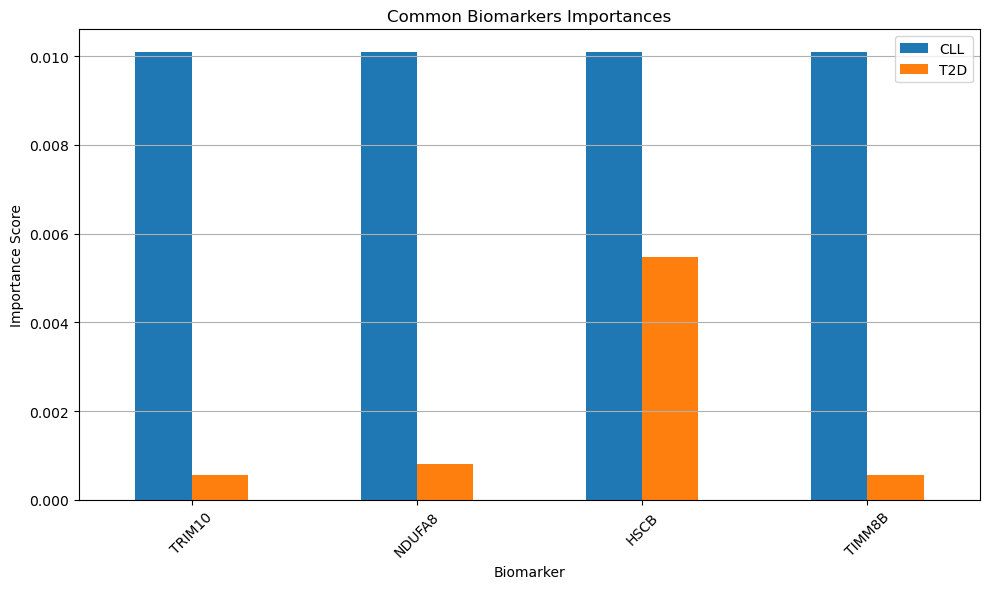

In [22]:
# Plot the common biomarkers importances for both datasets
def plot_common_biomarkers_grouped(importances1, importances2, common_biomarkers):
    # Create a DataFrame containing both importance scores for the common biomarkers
    data = pd.DataFrame({
        'CLL': importances1[common_biomarkers],
        'T2D': importances2[common_biomarkers]
    }, index=common_biomarkers)
    # Create a grouped barplot
    ax = data.plot(kind='bar', figsize=(10, 6), rot=45)
    ax.set_title("Common Biomarkers Importances")
    ax.set_ylabel("Importance Score")
    ax.set_xlabel("Biomarker")
    ax.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

plot_common_biomarkers_grouped(cll_feature_importances, t2d_feature_importances, cll_t2d_common_biomarkers)